In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput
import os
import global_settings

In [2]:
#result = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results/1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz",
    #"/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/f542d3ebd37584291a4d8e9cef5b95f7.tar.gz"
#)

# constrained
result = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results_fixed/e0518d85d27f313f2d617314dcd8386b.tar.gz",
    #"/home/gw/data/experiments/master_thesis/results_fixed/0b8d29190c9aeae7577197a46198a97d.tar.gz",
    "/home/gw/data/experiments/master_thesis/results_fixed/25a6723e6c442799e19c4876bdd06f4b.tar.gz",
)

experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()

normalized probabilities: [0.5665243  0.3504857  0.08298998]


# how is the parameters vector flattened

In [3]:
print(result.samples["parameters"][0])

[ 0.00718989  0.01227382  0.8192634  -0.3497398   0.3611419   1.015516
 -0.59161633 -0.5717157  -0.0794728   1.2910175  -4.1059527   4.532112
 -3.271341  ]


In [4]:
print(result.samples["params_layers_0_bias"][0])
print(result.samples["params_layers_0_kernel"][0])
print(result.samples["params_layers_2_bias"][0])
print(result.samples["params_layers_2_kernel"][0])
### --> column wise

[0.00718989 0.01227382 0.8192634 ]
[[-0.3497398   0.3611419   1.015516  ]
 [-0.59161633 -0.5717157  -0.0794728 ]]
[1.2910175]
[[-4.1059527]
 [ 4.532112 ]
 [-3.271341 ]]


samples_parameters_fs.shape (1274, 13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.28it/s]


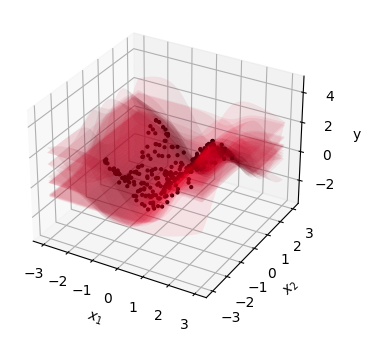

In [5]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

In [6]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "fs_full.png"), bbox_inches="tight", dpi=96)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


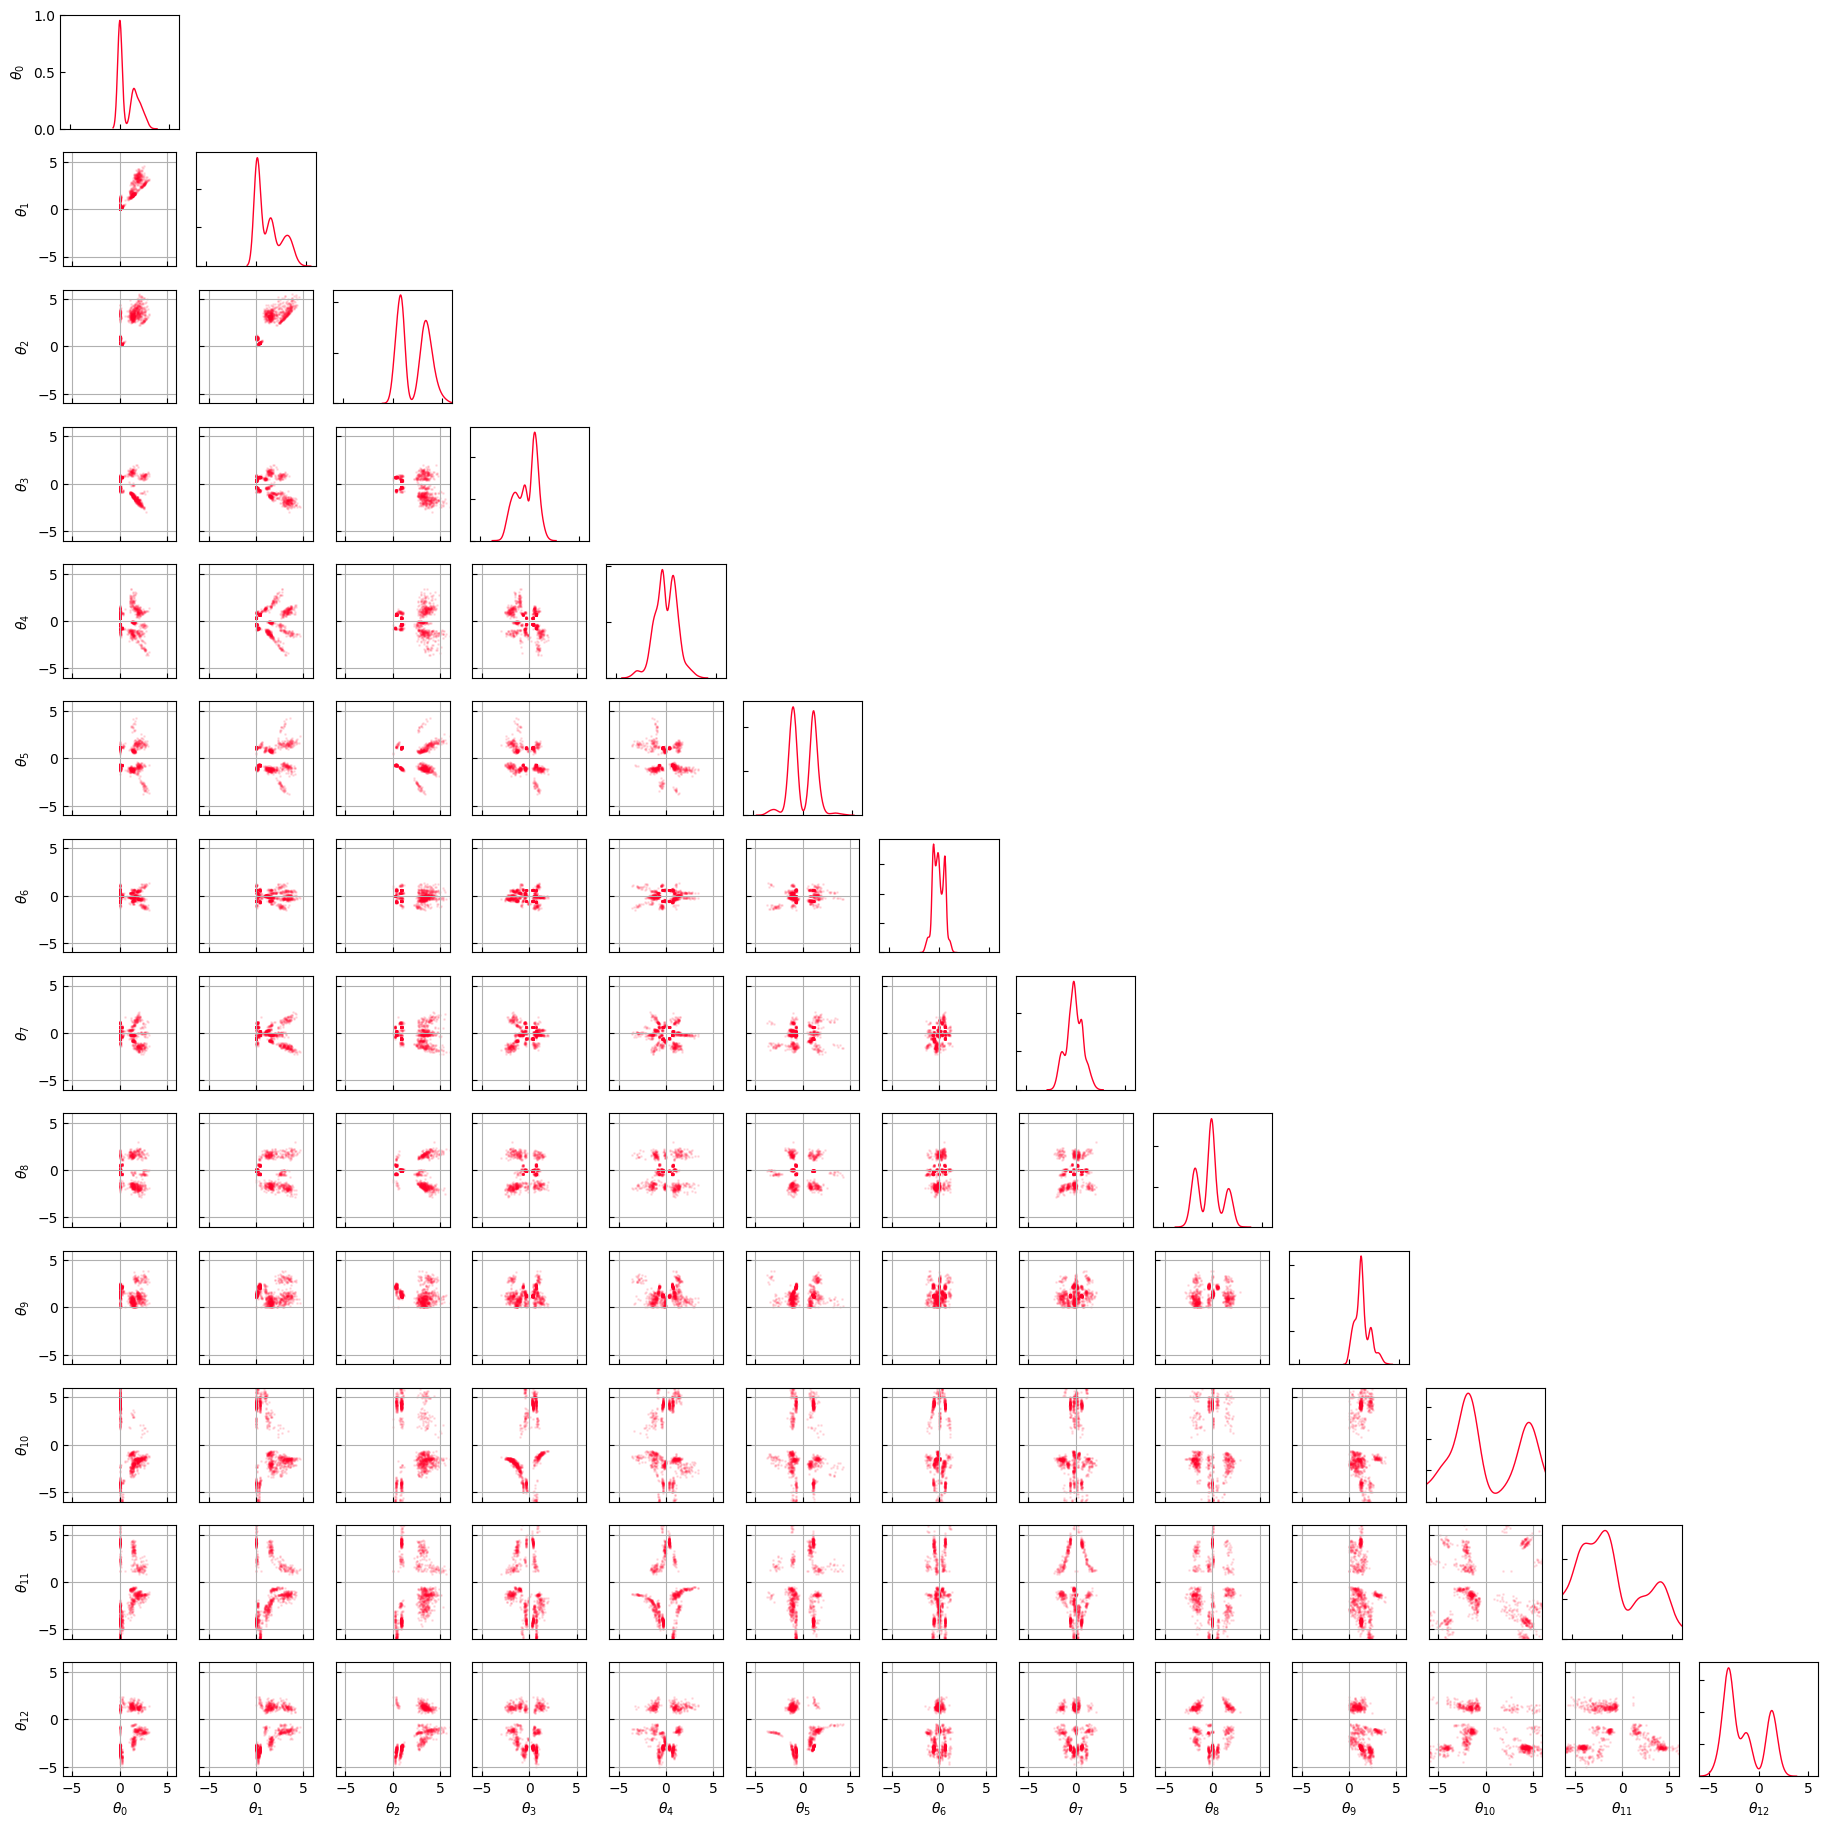

In [7]:
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters_posterior = samples_parameters_fs
#if samples_parameters_posterior.shape[-1] > 10:
#    samples_parameters_posterior = samples_parameters_posterior[:, jax.random.permutation(rng_key_, jnp.arange(samples_parameters_fs.shape[-1]))[:10]]

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.1,
            size=1.0
        )
    )
)
figure.plot(
    data_list=[samples_parameters_posterior]
)

In [8]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "posterior_full.png"), bbox_inches="tight", dpi=96)

# visualizing layerwise merged marginal posterior distributions

In [9]:
sequential_helper = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters = sequential_helper.structured_sequential_samples_parameters(
    samples_parameters=result.samples["parameters"]
)
symmetry_helper = equioutput.SymmetryHelper(structured_sequential_samples_parameters)

In [10]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
print(subspace_0.shape)

(1274, 3, 4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


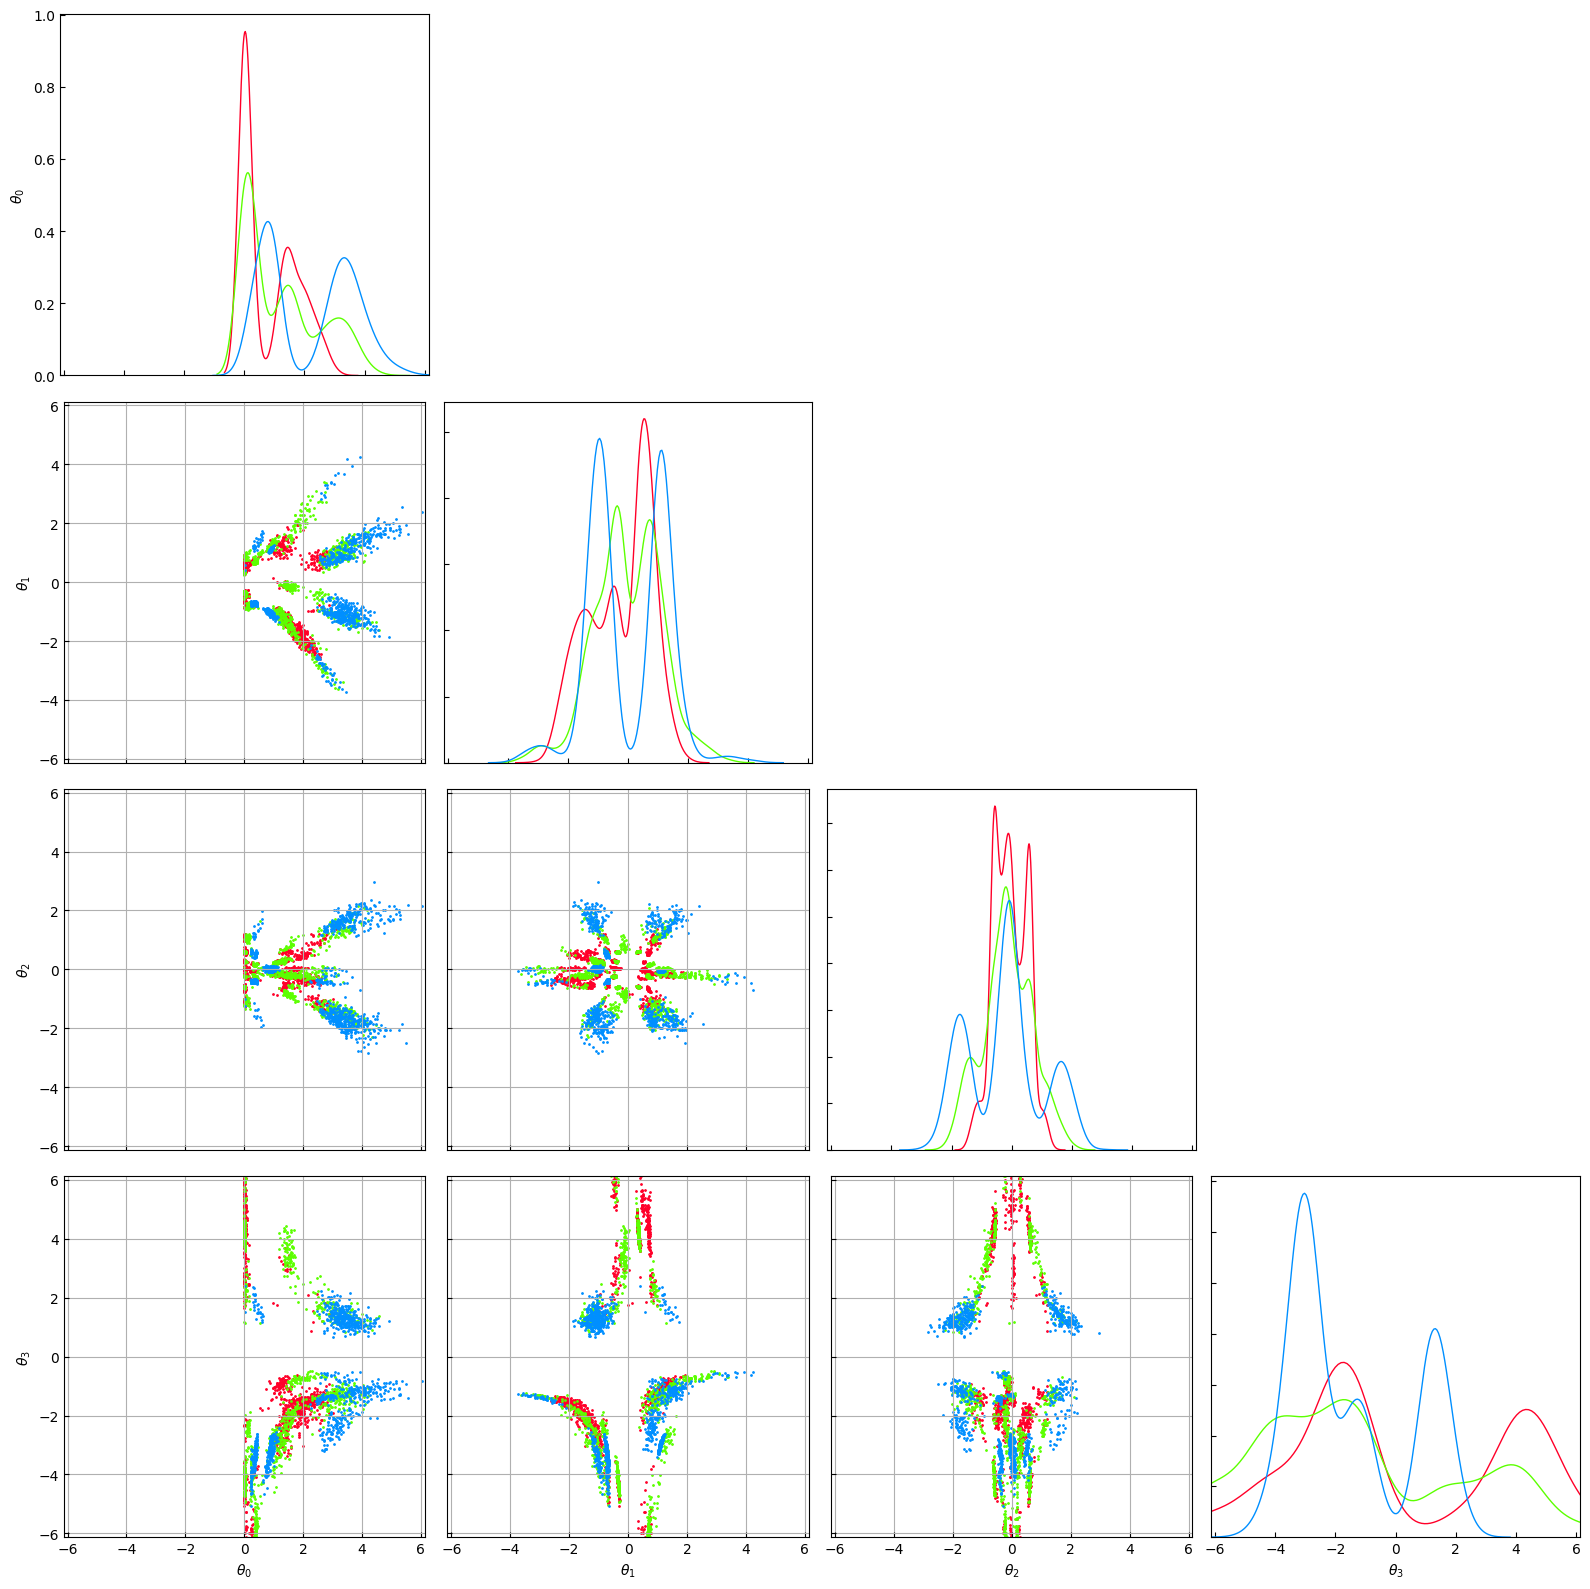

In [11]:
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        )
    )
)
figure.plot(
    data_list=data_list
)

In [12]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged.png"), bbox_inches="tight", dpi=96)

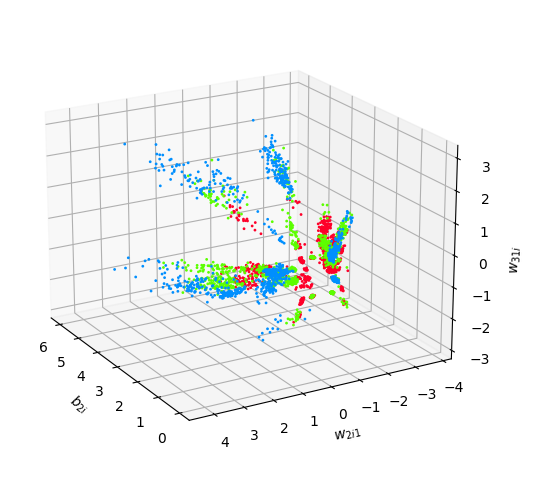

In [13]:
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap("gist_rainbow")

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(1, 1, 1, projection="3d")
for h in range(subspace_0.shape[-2]):
    color = cmap(1.0 * h / subspace_0.shape[-2])
    ax.scatter(subspace_0[:, h, 0], subspace_0[:, h, 1], subspace_0[:, h, 2], alpha=0.99, s=1, color=color)

#ax.scatter(0, 0, 0, alpha=0.99, s=100, c="black", marker='+')
#sample = 0
#ax.scatter(subspace_0[sample, 2, 0], subspace_0[sample, 2, 1], subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.scatter(-subspace_0[sample, 2, 0], -subspace_0[sample, 2, 1], -subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.plot(
#    [subspace_0[sample, 2, 0], -subspace_0[sample, 2, 0]],
#    [subspace_0[sample, 2, 1], -subspace_0[sample, 2, 1]],
#    [subspace_0[sample, 2, 2], -subspace_0[sample, 2, 2]], alpha=0.99, color=color)

ax.set_xlabel(r"$b_{2i}$")
ax.set_ylabel(r"$w_{2i1}$")
ax.set_zlabel(r"$w_{31i}$")

#ax.view_init(20, 210)
ax.view_init(20, 150)
figure

In [14]:
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_1.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_2.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_3.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_merged.png"), bbox_inches="tight", dpi=96)